In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import LatentDirichletAllocation
import warnings
from sklearn.model_selection import train_test_split

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [2]:
%load_ext autoreload
%autoreload 2

### Read Clean Data

- To get Based on your Occupation, etc., group by users with Occupation and average embeddings.

In [3]:
data = pd.read_csv('./data/clean/move-lens-100k-all.csv').set_index(['user_id', 'item_id', 'timestamp'])

assert not data.reset_index()[['user_id', 'item_id']].duplicated().any()

data['rating'] = (data.rating >= 4).astype(int)
data.head()

rating  gender_F  gender_M  \
user_id item_id timestamp                               
259     286     874724727       1         0         1   
        185     874724781       1         0         1   
        173     874724843       1         0         1   
        288     874724905       0         0         1   
        117     874724988       1         0         1   

                           occupation_administrator  occupation_artist  \
user_id item_id timestamp                                                
259     286     874724727                         0                  0   
        185     874724781                         0                  0   
        173     874724843                         0                  0   
        288     874724905                         0                  0   
        117     874724988                         0                  0   

                           occupation_doctor  occupation_educator  \
user_id item_id timestamp                                           
259     286     874724727                  0                    0   
        185     874724781                  0                    0   
        173     874724843                  0                    0   
        288     874724905                  0                    0   
        117     874724988                  0                    0   

                           occupation_engineer  occupation_entertainment  \
user_id item_id timestamp                                                  
259     286     874724727                    0                         0   
        185     874724781                    0                         0   
        173     874724843                    0                         0   
        288     874724905                    0                         0   
        117     874724988                    0                         0   

                           occupation_executive  ...  genre_Western  \
user_id item_id timestamp                        ...                  
259     286     874724727                     0  ...              0   
        185     874724781                     0  ...              0   
        173     874724843                     0  ...              0   
        288     874724905                     0  ...              0   
        117     874724988                     0  ...              0   

                           genre_unknown  release_decade_1920.0  \
user_id item_id timestamp                                         
259     286     874724727              0                      0   
        185     874724781              0                      0   
        173     874724843              0                      0   
        288     874724905              0                      0   
        117     874724988              0                      0   

                           release_decade_1930.0  release_decade_1940.0  \
user_id item_id timestamp                                                 
259     286     874724727                      0                      0   
        185     874724781                      0                      0   
        173     874724843                      0                      0   
        288     874724905                      0                      0   
        117     874724988                      0                      0   

                           release_decade_1950.0  release_decade_1960.0  \
user_id item_id timestamp                                                 
259     286     874724727                      0                      0   
        185     874724781                      0                      1   
        173     874724843                      0                      0   
        288     874724905                      0                      0   
        117     874724988                      0                      0   

                           release_decade_1970.0  release_decade_1980.0

### Train LDA

In [189]:
# prepare data
X = data.rating.to_numpy().reshape(-1, 1) * data.drop('rating', axis=1).to_numpy()
# split data into train & test
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('rating', axis=1).multiply(data.rating, axis=0), 
    data.rating,
    test_size=0.50, 
    random_state=42, 
    stratify=data.rating
)

# init LDA
lda = LatentDirichletAllocation(n_components=5, random_state=0)
lda.fit(X_train)
# get topics for some given samples:
lda.transform(X[-2:])

/Users/marialentini/miniforge3/envs/aplus_env/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LatentDirichletAllocation was fitted with feature names
  warnings.warn(


array([[0.2, 0.2, 0.2, 0.2, 0.2],
       [0.2, 0.2, 0.2, 0.2, 0.2]])

### Get User, Item Embeddings

In [62]:
# get transformed dataset
result = pd.DataFrame(lda.transform(X_train))
# add index back in
result.index = X_train.index

# user embeddings
user_embs = result.groupby(result.index.get_level_values('user_id')).mean()
# item embeddings
item_embs = result.groupby(result.index.get_level_values('item_id')).mean()

result.head()

,,,0,1,2,3,4
user_id,item_id,timestamp,,,,,
436,273,887769233,0.303781,0.033674,0.033946,0.594744,0.033856
94,25,891724142,0.200000,0.200000,0.200000,0.200000,0.200000
843,288,879443544,0.033924,0.033785,0.864136,0.034216,0.033939
727,748,883708119,0.033847,0.304049,0.033667,0.033820,0.594616
90,245,891382612,0.200000,0.200000,0.200000,0.200000,0.200000


### Visualize User, Item Embeddings

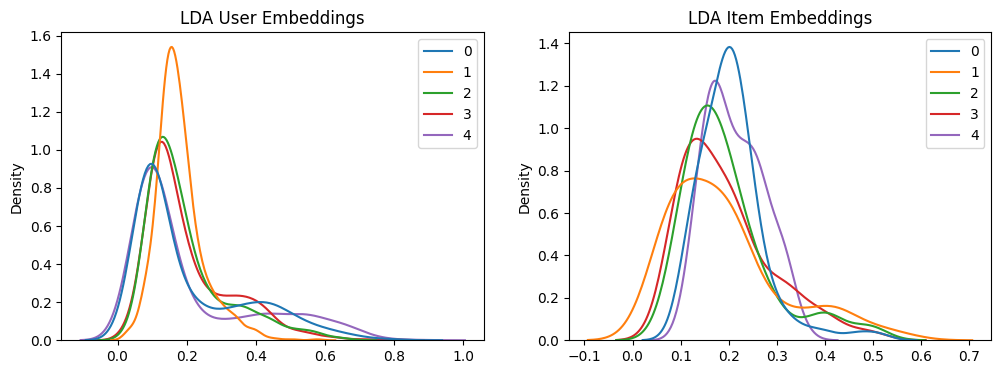

In [63]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

sns.kdeplot(user_embs, ax=ax[0])
sns.kdeplot(item_embs, ax=ax[1])

ax[0].set_title('LDA User Embeddings')
ax[1].set_title('LDA Item Embeddings')

plt.show()

### Try Replayer Experiment

In [64]:
# get user, item similarity matrix
user_item_sims = user_embs @ item_embs.T / np.linalg.norm(user_embs) / np.linalg.norm(item_embs)

user_item_sims.head()

item_id,1,7,8,9,11,12,15,22,25,28,...,471,475,483,496,546,568,655,678,742,748
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.001954,0.002144,0.002060,0.002242,0.001973,0.001897,0.002265,0.002223,0.002117,0.002332,...,0.002153,0.002091,0.002259,0.002093,0.002369,0.002515,0.002924,0.002429,0.002211,0.002429
2,0.003812,0.001974,0.002898,0.001900,0.002934,0.003054,0.002081,0.001973,0.003375,0.002491,...,0.001954,0.001873,0.001953,0.002049,0.002355,0.002406,0.002279,0.002463,0.002106,0.002430
3,0.002330,0.002559,0.002466,0.002652,0.002392,0.002395,0.002610,0.002461,0.002374,0.002483,...,0.002543,0.002548,0.002549,0.002554,0.002483,0.002422,0.002350,0.002527,0.002545,0.002424
4,0.002583,0.002686,0.002709,0.002928,0.002665,0.002754,0.002881,0.002493,0.002571,0.002672,...,0.002680,0.002763,0.002363,0.002428,0.002644,0.002475,0.002115,0.002722,0.002828,0.002474
5,0.003367,0.002024,0.002697,0.001972,0.002714,0.002785,0.002115,0.002053,0.003072,0.002447,...,0.002013,0.001937,0.002043,0.002080,0.002355,0.002431,0.002431,0.002439,0.002130,0.002432


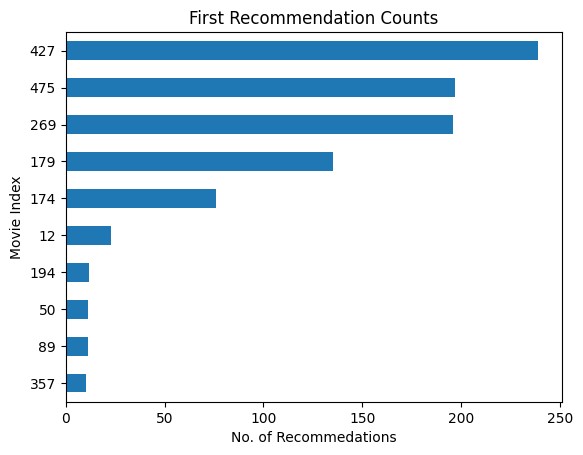

In [65]:
user_item_sims.T.idxmax().value_counts().head(10)[::-1].plot(kind='barh')

plt.title('First Recommendation Counts')
plt.ylabel('Movie Index')
plt.xlabel('No. of Recommedations')
plt.show()

For this iteration, we do not take a train or test split, or consider how the user, item embeddings update sequentially over time. This experiment to baseline performance assuming we have all information about a user, even information "from the future."

In [66]:
# get list of liked items from user
user_support = data.reset_index().groupby('user_id').item_id.apply(lambda x: list(x)).to_dict()

# get unique user, item IDs
user_ids = data.index.get_level_values('user_id').unique()
item_ids = data.index.get_level_values('item_id').unique()

# track user recs
user_recs = {user_id: item_ids.tolist() for user_id in user_ids}

rec_item_ratings = []
for _ in range(1):
    for user_id, item_id, rating in data.reset_index()[['user_id', 'item_id', 'rating']].to_numpy(): 
        # make a movie recommendation
        rec_item_id = user_item_sims.loc[user_id, user_recs[user_id]].idxmax()

        if rec_item_id == item_id:
            # append item rating
            rec_item_ratings.append(rating)
            # remove item from user support
            user_recs[user_id].remove(item_id)

print('Average MovieLens 100K Rating:', data.rating.mean())
print('Recommendations made:', len(rec_item_ratings))
print('Average Rating of Recs:', np.mean(rec_item_ratings))

Average MovieLens 100K Rating: 0.67004109451739
Recommendations made: 501
Average Rating of Recs: 0.8203592814371258


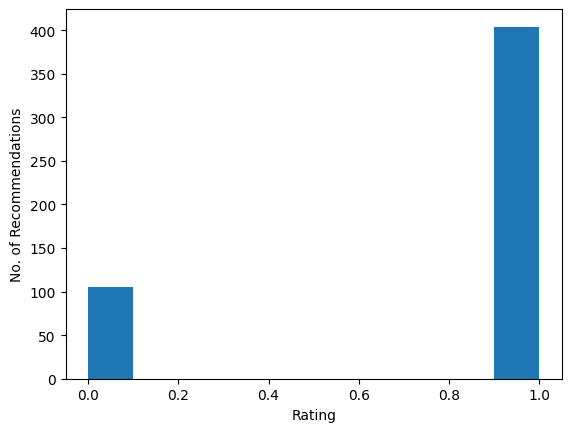

In [32]:
plt.hist(rec_item_ratings)

# print(sum(np.array(rec_item_ratings)>= 3) / len(rec_item_ratings))
plt.xlabel('Rating')
plt.ylabel('No. of Recommendations')
plt.show()

### Sequential Recommendation

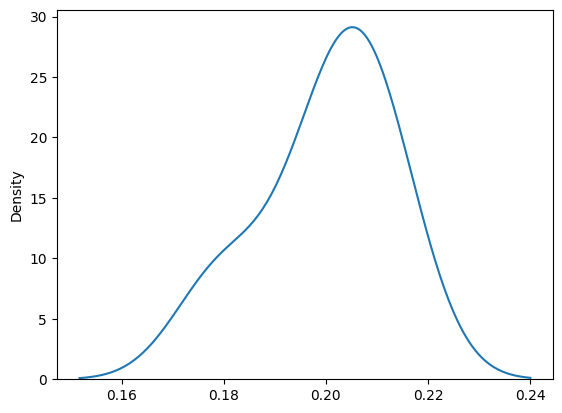

In [67]:
# cold start rec take avg of all users
user_cold_start_emb = user_embs.mean(axis=0).tolist()
sns.kdeplot(user_cold_start_emb)

plt.show()

In [68]:
# get list of liked items from user
user_support = data.reset_index().groupby('user_id').item_id.apply(lambda x: list(x)).to_dict()

user_ids = data.index.get_level_values('user_id').unique()
item_ids = data.index.get_level_values('item_id').unique()
user_embs_seq = {user_id: user_cold_start_emb for user_id in user_ids}

# pred rating_matrix
user_embs_seq = {user_id: user_cold_start_emb for user_id in user_ids}

# track user recs
user_recs = {user_id: item_ids.tolist() for user_id in user_ids}
# predicted rating matrix
pred_ratings = (item_embs @ pd.DataFrame(user_embs_seq)).T / np.linalg.norm(item_embs) / np.linalg.norm(pd.DataFrame(user_embs_seq))

# track number of user ratings
user_n_ratings = {user_id: 0 for user_id in data.index.get_level_values('user_id').unique()}

rec_item_ratings = []
for _ in range(1):
    for user_id, item_id, rating in data.reset_index()[['user_id', 'item_id', 'rating']].to_numpy(): 
        # make a movie recommendation
        rec_item_id = pred_ratings.loc[user_id, user_recs[user_id]].idxmax()

        # random selection
        # rec_item_id = np.random.choice(user_recs[user_id])

        if rec_item_id == item_id:
            # append item rating
            rec_item_ratings.append(rating)
            # remove item from user support
            user_recs[user_id].remove(item_id)
            # look up user, item datapoint
            x = data.loc[user_id, item_id]
            # get new user embedding
            v_new = lda.transform((x.drop('rating', axis=1) * x['rating'].iloc[0]).to_numpy())
            # get old user embedding
            v_old = user_embs_seq[user_id]
            # get no. of user ratings
            n = user_n_ratings[user_id] + 1 
            # update user embedding
            user_embs_seq[user_id] = (1 / (n + 1)) * (n * v_old + v_new)
            # update rating estimates
            pred_ratings.loc[user_id] = (item_embs @ user_embs_seq[user_id].T).values.reshape(1, -1)
            # udpate user rating count
            user_n_ratings[user_id] += 1

print('Average MovieLens 100K Rating:', data.rating.mean())
print('Recommendations made:', len(rec_item_ratings))
print('Average Rating of Recs:', np.mean(rec_item_ratings))

/Users/marialentini/miniforge3/envs/aplus_env/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LatentDirichletAllocation was fitted with feature names
  warnings.warn(
/Users/marialentini/miniforge3/envs/aplus_env/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LatentDirichletAllocation was fitted with feature names
  warnings.warn(
/Users/marialentini/miniforge3/envs/aplus_env/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LatentDirichletAllocation was fitted with feature names
  warnings.warn(
/Users/marialentini/miniforge3/envs/aplus_env/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LatentDirichletAllocation was fitted with feature names
  warnings.warn(
/Users/marialentini/miniforge3/envs/aplus_env/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning:

Average MovieLens 100K Rating: 0.67004109451739
Recommendations made: 327
Average Rating of Recs: 0.8623853211009175


## Use API to Run Experiment

In [4]:
from sklearn.decomposition import NMF
from sklearn.decomposition import FastICA
from src.replayer import replayer

### Split Data

In [5]:
# 50 / 50 split
n = 5 * len(data) // 10
X_train = data.drop('rating', axis=1)[:n]
X_test = data.drop('rating', axis=1)[n:]

y_train = data.rating[:n]
y_test = data.rating[n:]

### Run Experiment

In [7]:
# init LDA
lda = LatentDirichletAllocation(n_components=5, random_state=0)
# init replayer
play = replayer(lda)
# fit data on train
play.fit(X_train, y_train)
# test out-of-sample
ratings = play.test(X_test, y_test)

print('Average MovieLens 100K Rating:', y_test.mean())
print('Test: Recommendations made:', len(ratings))
print('Test: Average Rating of Recs:', np.mean(ratings))

Average MovieLens 100K Rating: 0.6544166778030202
Test: Recommendations made: 177
Test: Average Rating of Recs: 0.8135593220338984


In [350]:
from src.replayer import replayer

# init LDA
nmf = NMF(n_components=2, init='random', random_state=0)
# init replayer
play = replayer(nmf)
# fit data on train
play.fit(X_train, y_train)
# test out-of-sample
ratings = play.test(X_test, y_test)

print('Average MovieLens 100K Rating:', y_test.mean())
print('Test: Recommendations made:', len(ratings))
print('Test: Average Rating of Recs:', np.mean(ratings))

Average MovieLens 100K Rating: 0.6544166778030202
Test: Recommendations made: 200
Test: Average Rating of Recs: 0.86


In [9]:
def run_experiment(models):
    """
    Run replayer experiment using different MF models.
    """
    # init results list
    results = []
    for model in models:
        play = replayer(model)
        # fit data on train
        play.fit(X_train, y_train)
        # test out-of-sample
        ratings = play.test(X_test, y_test)
        # append results
        results.append(
            { "model": str(model), "avg_oos_rating": np.mean(ratings), "n_recs": len(ratings)}
        )
    return pd.DataFrame(results)

# specify models to test
n_components = [3, 5, 7]
models = [
    LatentDirichletAllocation(n_components=2, random_state=0),
    LatentDirichletAllocation(n_components=3, random_state=0),
    NMF(n_components=2, init='random', random_state=0),
    NMF(n_components=3, init='random', random_state=0),
    FastICA(n_components=5, random_state=0, whiten='unit-variance'),
    FastICA(n_components=7, random_state=0, whiten='unit-variance')
]

# run experiment
results = run_experiment(models)
# show results
results

,model,avg_rating,n_recs
0,"LatentDirichletAllocation(n_components=2, rand...",0.842424,165
1,"LatentDirichletAllocation(n_components=3, rand...",0.821429,196
2,"NMF(init='random', n_components=2, random_stat...",0.860000,200
3,"NMF(init='random', n_components=3, random_stat...",0.848780,205
4,"FastICA(n_components=5, random_state=0)",0.800000,325
5,"FastICA(n_components=7, random_state=0)",0.793210,324


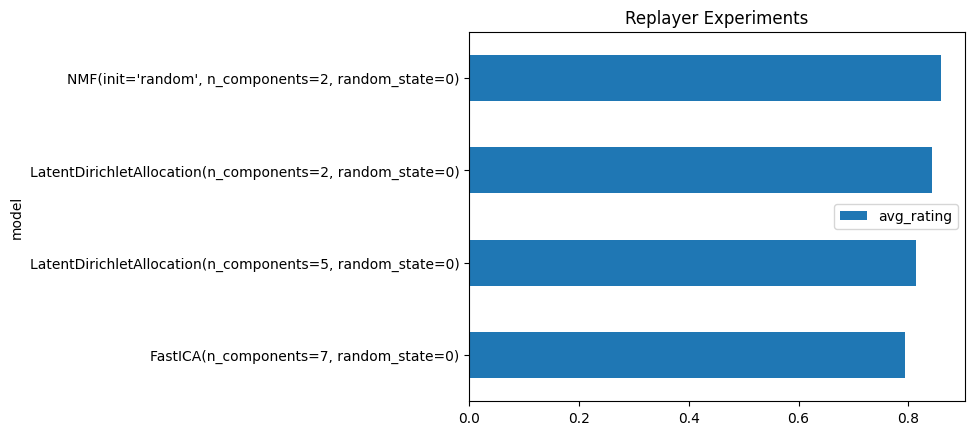

In [368]:
results.set_index('model').sort_values('avg_rating').plot(kind='barh')

plt.title("Replayer Experiments")
plt.show()

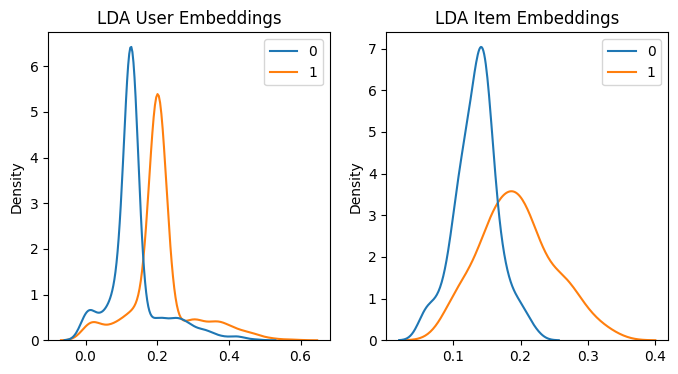

In [359]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

sns.kdeplot(pd.DataFrame(play.user_embs).T, ax=ax[0])
sns.kdeplot(pd.DataFrame(play.item_embs).T, ax=ax[1])

ax[0].set_title('LDA User Embeddings')
ax[1].set_title('LDA Item Embeddings')

plt.show()

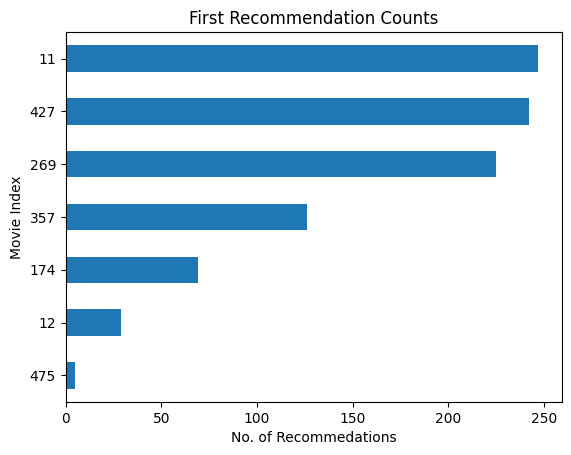

In [346]:
play.pred_ratings.T.idxmax().value_counts().head(10)[::-1].plot(kind='barh')

plt.title('First Recommendation Counts')
plt.ylabel('Movie Index')
plt.xlabel('No. of Recommedations')
plt.show()